In [40]:
import pandas as pd 
import geopandas as geo
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
# Import vote model predictions and BES 2024 GE results data
pred_df = pd.read_csv("VI Preds.csv")
actuals = pd.read_spss('BES-2024-General-Election-results-file-v1.0.sav')

# Read shapefile for UK parliamentary constituency boundaries to plot results
map_data = geo.read_file("Constituency Geodata/PCON_JULY_2024_UK_BUC.shp")
map_data = map_data[map_data["PCON24CD"].isin(pred_df["ONSConstID"].unique())]

In [42]:
# Generate number of voters from predicted probability of vote for each party
pred_df["Con_N"] = pred_df["TO N"]*pred_df["Con_Vote"]
pred_df["Lab_N"] = pred_df["TO N"]*pred_df["Lab_Vote"]
pred_df["LD_N"] = pred_df["TO N"]*pred_df["LD_Vote"]
pred_df["Oth_N"] = pred_df["TO N"]*pred_df["Oth_Vote"]

constituency_predictions = pred_df[["ONSConstID", "Observation","TO N","Con_N","Lab_N","LD_N","Oth_N"]].groupby("ONSConstID").sum()

In [43]:
# Compare BES 2024 results to predicted votes, then calculate scale for each constituency and each party
actuals["OthVote24"] = actuals["PCVote24"] + actuals["GreenVote24"] + actuals["RUKVote24"] + actuals["OtherVote24"] 
actuals_cols = actuals[["ONSConstID", "ConstituencyName", "ConVote24", "LabVote24", "LDVote24", "OthVote24"]]

pred_with_actuals = ONS_with_VI = pd.merge(actuals_cols, constituency_predictions, on=['ONSConstID'])

pred_with_actuals["LabScale"] = pred_with_actuals["LabVote24"]/pred_with_actuals["Lab_N"]
pred_with_actuals["ConScale"] = pred_with_actuals["ConVote24"]/pred_with_actuals["Con_N"]
pred_with_actuals["LDScale"] = pred_with_actuals["LDVote24"]/pred_with_actuals["LD_N"]
pred_with_actuals["OthScale"] = pred_with_actuals["OthVote24"]/pred_with_actuals["Oth_N"]

In [44]:
# Merge calculated scales with 
scaled_pred = pd.merge(pred_df, pred_with_actuals[['ONSConstID',"LabScale","ConScale","LDScale","OthScale"]], on=['ONSConstID'])

In [45]:
scaled_pred["Scaled_Lab"] = scaled_pred["Lab_N"]*scaled_pred["LabScale"]
scaled_pred["Scaled_Con"] = scaled_pred["Con_N"]*scaled_pred["ConScale"]
scaled_pred["Scaled_LD"] = scaled_pred["LD_N"]*scaled_pred["LDScale"]
scaled_pred["Scaled_Oth"] = scaled_pred["Oth_N"]*scaled_pred["OthScale"]

In [48]:
# Map winning party to colour to plot on map
party_cols = {
    "Con_N":'#0087DC', # Con
    "Lab_N":'#E4003B', # Lab
    "LD_N":'#FAA61A', # LD
    "Oth_N":'#6D6E71' # Other
}
constituency_predictions["Winner"] = constituency_predictions[["Con_N","Lab_N","LD_N","Oth_N"]].idxmax(axis="columns")
constituency_predictions["Colour"] = constituency_predictions["Winner"].map(party_cols)

colour_mapping = constituency_predictions["Colour"]

# append colour to map dataset
map_data["Colour"] = map_data["PCON24CD"].map(colour_mapping)

# Repeat for scaled results
constituency_scaled = scaled_pred[["ONSConstID", "Observation","Scaled_Lab","Scaled_Con","Scaled_LD","Scaled_Oth"]].groupby("ONSConstID").sum()

scale_party_cols = {
    "Scaled_Con":'#0087DC', # Con
    "Scaled_Lab":'#E4003B', # Lab
    "Scaled_LD":'#FAA61A', # LD
    "Scaled_Oth":'#6D6E71' # Other
}

constituency_scaled["Winner"] = constituency_scaled[["Scaled_Lab","Scaled_Con","Scaled_LD","Scaled_Oth"]].idxmax(axis="columns")
constituency_scaled["Colour"] = constituency_scaled["Winner"].map(scale_party_cols)

scale_colour_mapping = constituency_scaled["Colour"]

map_data["Scaled Colour"] = map_data["PCON24CD"].map(scale_colour_mapping)

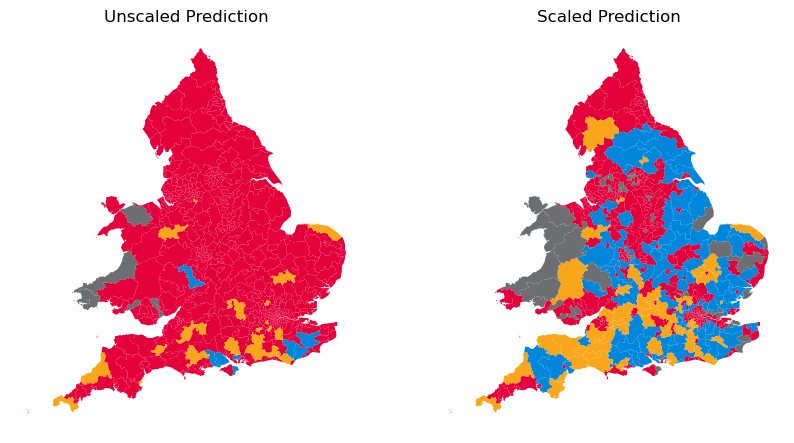

In [65]:
# Plot scaled and unscaled constituency level results on map
fig, axs = plt.subplots(1,2,figsize=(10,10))
map_data.plot(color=map_data["Colour"],ax=axs[0])
map_data.plot(color=map_data["Scaled Colour"],ax=axs[1])
for ax in axs:
    ax.tick_params(left=False, bottom=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
axs[0].set_title("Unscaled Prediction")
axs[1].set_title("Scaled Prediction")
sns.despine(left=True, right=True, bottom=True)

In [74]:
# Export final poststratificiation frame with scaled vote counts
final_frame = scaled_pred[['ONSConstID', 'AgeCat', 'ONSed', 'SexCat', 'Observation', 'Scaled_Lab','Scaled_Con', 'Scaled_LD', 'Scaled_Oth']]
final_frame.rename(columns={"Scaled_Lab":"Lab","Scaled_Con":"Con","Scaled_LD":"LD","Scaled_Oth":"Oth"},inplace=True)
final_frame.to_csv('Final Poststratification Frame.csv')